# Advanced-Lane-Lines

## External Modules 
loading all external modules for our project need

In [1]:
from copy import deepcopy
from pathlib import Path
import os 
import cv2 
import numpy as np
import random 
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

-----
## Helper Functions 

### File read/save helpers  

In [2]:
def load_saved_data(data_path):
    data_path_chk = Path(data_path).is_file()
    if data_path_chk:
        with open(data_path,'rb') as fp:
            saved_data = pickle.load(fp)
        return saved_data
    else:
         raise LookupError("can't find {}".format(data_path))

            
def save_data_to_path(data_path, data):
    with open(data_path, 'wb') as fp:
        pickle.dump(data, fp)

### Other helper functions 

In [3]:
# given a folder path with criteria, randomly select one file within the folder that match the criteria 
def rand_select_img_from_folder(path):
    files_list = []

    images = glob.glob(path)

    for idx, fname in enumerate(images):
        files_list.append(fname)

    return random.choice(files_list)


def select_all_img_from_folder(path):
    files_list = []

    images = glob.glob(path)

    for idx, fname in enumerate(images):
        yield fname

        
# plot two images side by side, for comparison  
def plot_org_vs_mod(org_img, mod_img, org_label='Original Image', mod_label='Undistorted Image',cmap='jet'):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    f.tight_layout()

    ax1.imshow(org_img,cmap=cmap)
    
    ax1.set_title(org_label, fontsize=30)
    
    ax2.imshow(mod_img,cmap=cmap)
    
    ax2.set_title(mod_label, fontsize=30)
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

----
## Camera Calibration 

### chessboard conners  

this helper function take chessboard pictures within a folder, and output the desired object points(chessboard conners) array with the corresponding points array within original pictures  

In [4]:
def path_imgs_objpnts_imgpnts(path,nx,ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(path)

    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints 

### Load/save chessboard corners
the helper will load the pre-existing desired conners array with chessboard conners array. If file(s) doen't exist, involking the above helper and save the results to disire paths  

In [5]:
cal_images_path = "./camera_cal/*.jpg"
objpoints_path = "./camera_cal/objpoints"
imgpoints_path = "./camera_cal/imgpoints"
nx = 9
ny = 6

try:
    objpoints = load_saved_data(objpoints_path)
    imgpoints = load_saved_data(imgpoints_path)
except:
    objpoints, imgpoints = path_imgs_objpnts_imgpnts(cal_images_path,nx,ny)
    save_data_to_path(objpoints_path,objpoints)
    save_data_to_path(imgpoints_path,imgpoints)


### Calibration and undistotion
calibrate camera by using desire and images chessboard conners from above with the desire image size, to generate a transformation matrix for undistortion. Then use the transformation to undistore a given picture that feed into the function  

In [6]:
def cal_cam_and_undist_img(org_img, objpoints, imgpoints):
    
    img_size = (org_img.shape[1],org_img.shape[0])

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    undst_img = cv2.undistort(org_img, mtx, dist, None, mtx)
    
    return  org_img, undst_img

# higher order function that read in a path of the image and then apply calibration and undistortion 
def read_path_cal_undust(img_path, objpoints, imgpoints):
    org_img = cv2.imread(img_path)
    return cal_cam_and_undist_img(org_img, objpoints, imgpoints)

### Testing on chessboard image

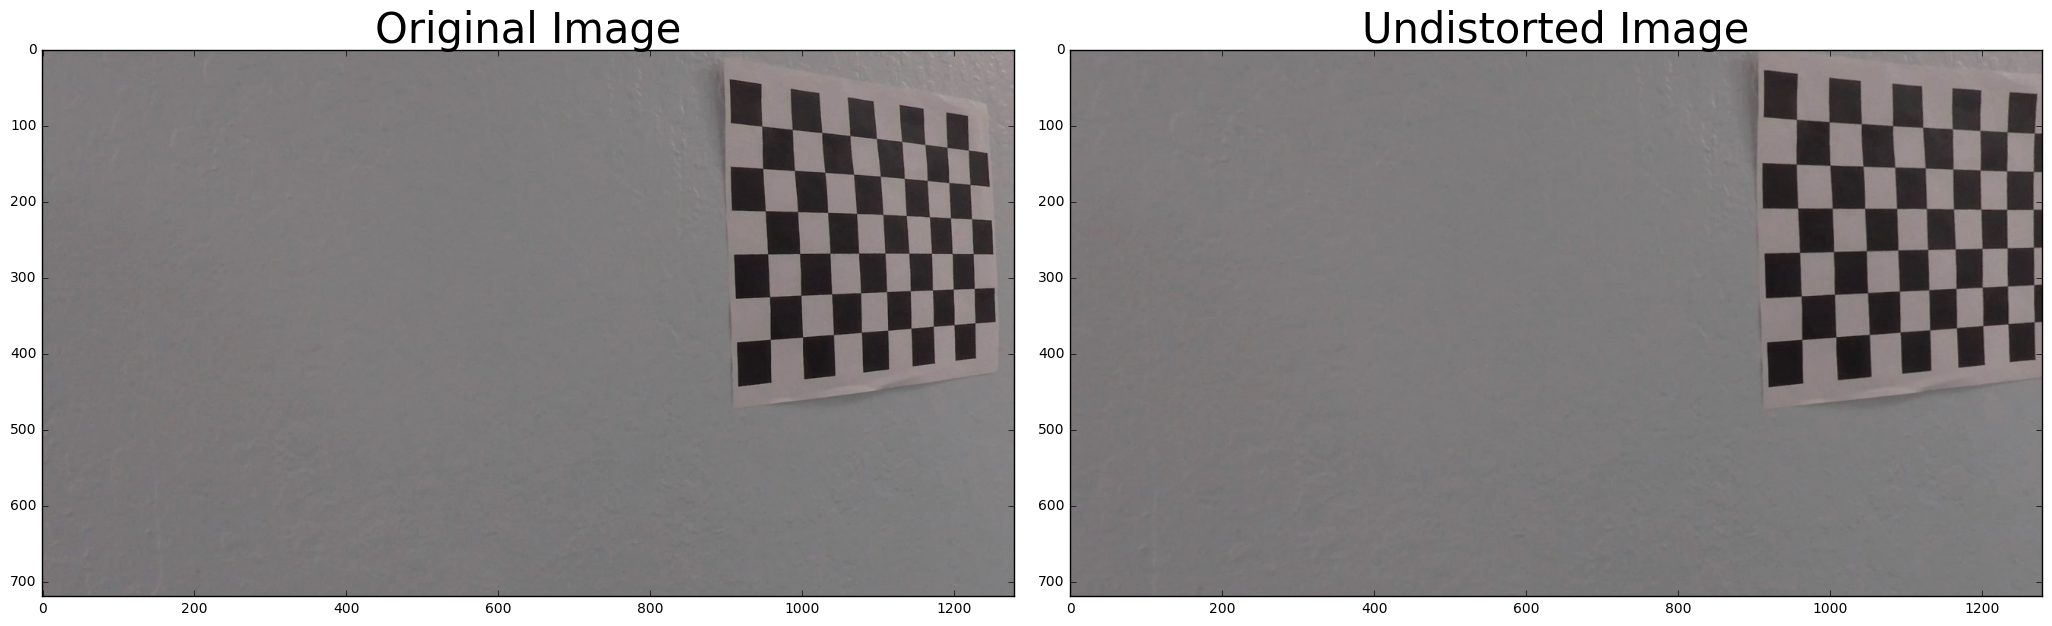

In [7]:
# test_images_path = "./test_images/*.jpg"
%matplotlib inline

rand_chess_img_path = rand_select_img_from_folder(cal_images_path)

org_img,undst_img = read_path_cal_undust(rand_chess_img_path, objpoints, imgpoints)

plot_org_vs_mod(org_img, undst_img)

### Testing on driving image 

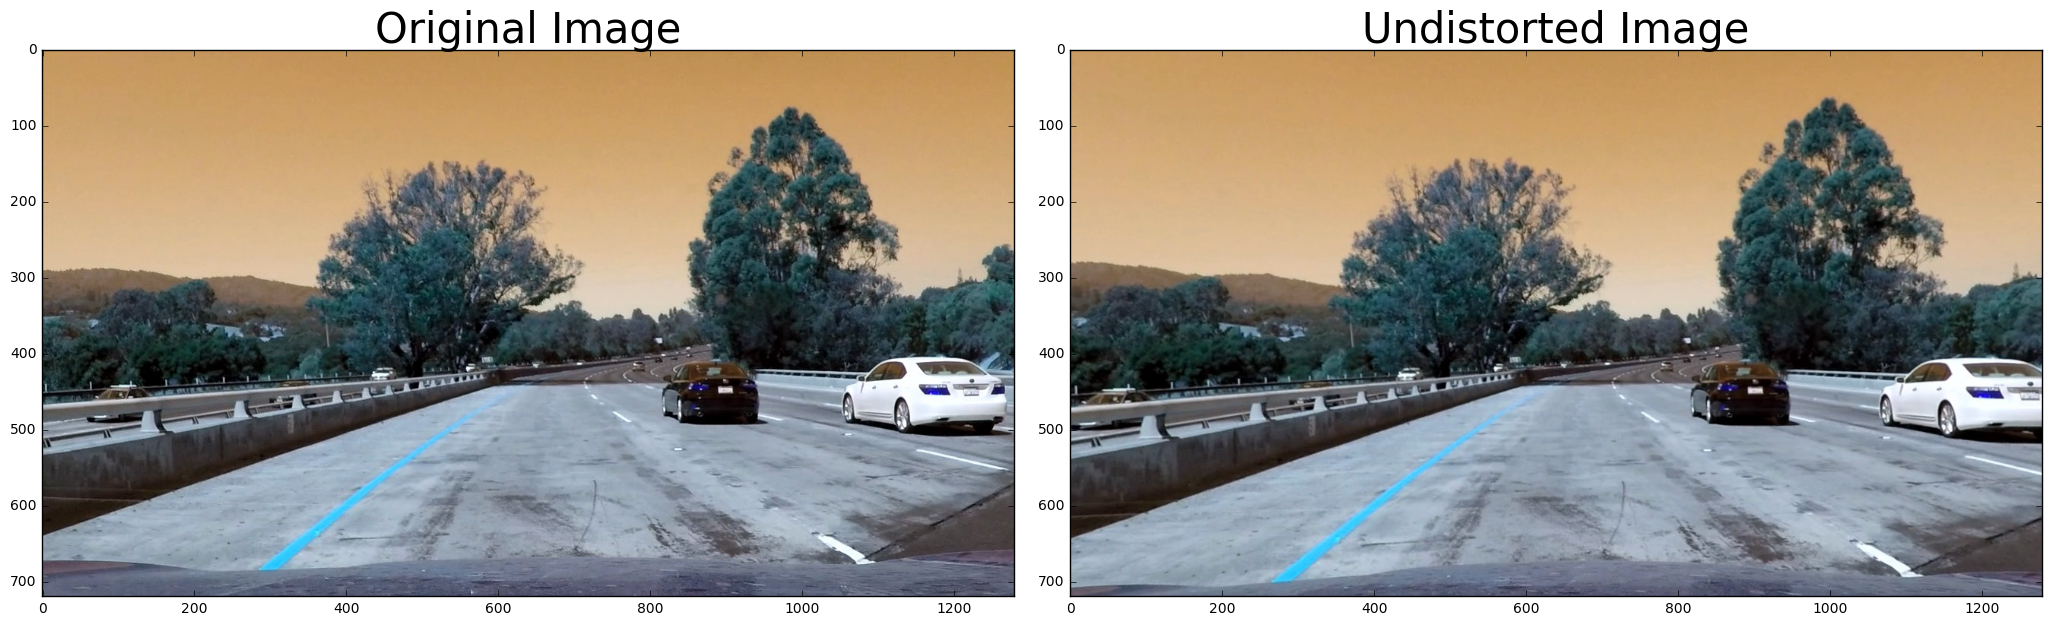

In [8]:
%matplotlib inline

test_images_path = "./test_images/*.jpg"

rand_test_img_path = rand_select_img_from_folder(test_images_path)

org_img_test,undst_img_test = read_path_cal_undust(rand_test_img_path, objpoints, imgpoints)

plot_org_vs_mod(org_img_test, undst_img_test)

----
## Lane Line Detection 
There are three major steps that we use for Lane line detection, there are 
1. transformations
2. lane-line fitting
3. lane region highlighting 
4. curvature & center line calculation
5. the complete pipeline

### 1-Transformations
There three transformation steps we will use in here:
1. persepective transformation
2. HLS transfomation
3. sobel transfomation

Also, we will create a pipeline function to take in an image and apply the above image, to obtain an binary image that has lane line shape within the specified distance 

#### persepective transformation
the main idea for persepective transformation is to transform a desire area within an image from 3-D perspect to 2-D perspect  

In [9]:
def perspective_transform(img, src_crn, offset):
    
    img_size = (img.shape[1], img.shape[0])
    
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    
    
    M = cv2.getPerspectiveTransform(src_crn, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src_crn)

    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped, M, Minv

####  HLS transfomation

In [10]:
def hls_select(img, thresh=(0, 190)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

def rgb_select(img, thresh=(0, 255)):
#     hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    binary_output = np.zeros_like(B)
    binary_output[(B > thresh[0]) & (B <= thresh[1])] = 1
    return binary_output



#### sobel transformation

##### higher order sobel functions helpers 

In [11]:
# calculate soble value for the x and y directions with provided kernel 
def conv_img_sobel_x_y(img, sobel_kernel):
    img = deepcopy(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_gray_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_gray_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return sobel_gray_x,sobel_gray_y

# given the transformed binary image and thresholes, output the new binary image that within the threshole rage 
def thresh_sobel_binary_output(sobel_gray, thresh):
    (thresh_min,thresh_max) = thresh 
    binary_output = np.zeros_like(sobel_gray)
    binary_output[(sobel_gray >= thresh_min) & (sobel_gray <= thresh_max)] = 1
    return binary_output

##### Type of soble transformations 

In [12]:
# direction sobel
def sobel_dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobel_gray_x, sobel_gray_y = conv_img_sobel_x_y(img, sobel_kernel)
    sobel_gray = np.arctan2(np.absolute(sobel_gray_y),np.absolute(sobel_gray_x))
    return thresh_sobel_binary_output(sobel_gray, thresh)

# magnitude sobel    
def sobel_mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobel_gray_x, sobel_gray_y = conv_img_sobel_x_y(img, sobel_kernel)
    sobel_gray = np.sqrt(np.power(sobel_gray_x,2)+np.power(sobel_gray_y,2))
    abs_sobel_gray = np.absolute(sobel_gray)
    scaled_sobel = np.uint8(255*abs_sobel_gray/np.max(abs_sobel_gray))
    return thresh_sobel_binary_output(scaled_sobel,mag_thresh)

# absolute axis wise soble 
def sobel_abs_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    (thresh_min,thresh_max) = thresh 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    (x,y) = (0,1) if orient=='y' else (1,0)
    sobel_gray = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    abs_sobel_gray = np.absolute(sobel_gray)
    scaled_sobel = np.uint8(255*abs_sobel_gray/np.max(abs_sobel_gray))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output

#### Transformations pipeline

In [13]:
def transformation_pipe_line(image, objpoints, imgpoints, ksize=3):
    
    # we want to undistore the image first 
    org_img_test,image = cal_cam_and_undist_img(image, objpoints, imgpoints)
      
    im_copy = np.copy(image)

    gradx = sobel_abs_thresh(im_copy, 'x', ksize, thresh=(10, 255))

    grady = sobel_abs_thresh(im_copy, 'y', ksize, thresh=(60, 255))

    mag_binary = sobel_mag_thresh(im_copy, ksize, mag_thresh=(40, 255))

    dir_binary = sobel_dir_threshold(im_copy, ksize, thresh=(0.65, 1.05))    

    combined_sbl = np.zeros_like(dir_binary)

    combined_sbl[((gradx == 1) & (grady == 1)) |((mag_binary == 1) & (dir_binary == 1))] = 1    

    
    im_copy_2 = np.copy(image)
    
    s_thresh = (140,255)
    
    s_slected = hls_select(im_copy_2,s_thresh)
    
    combined = np.zeros_like(s_slected)
    
    combined[((combined_sbl == 1) | (s_slected == 1))]=1
    
    src_crn = np.float32([[585,460], [695,460], [1127, 690], [310,690]])

    perspective_T_img, m, Minv = perspective_transform(combined, src_crn, 100)

    return org_img_test, perspective_T_img, Minv

### 2-Lane line fitting
After the above image manipulations, we want to find out where the lanes location in a bianry prespective transformed image. In here we only using sliding window technique for each frame. The idea behind the sliding window technique is based on histrogram to identify the peak pixels regions, which can correspond to lane lines itself. 

After the points for the line line have been identified, one can fit a second order polynominal function to reconstruct the main curvacture of the lane line.

In [14]:
def init_search_left_right_lane_points(binary_warped, nwindows=9, margin=100, minpix=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    return  left_lane_inds,right_lane_inds, nonzeroy, nonzerox, out_img, [(leftx,lefty),(rightx,righty)]


def continue_search_left_right_lane_points(binary_warped, left_fit, right_fit, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return [(leftx,lefty),(rightx,righty)]

def fit_lane(y, x, ploty):
    fit = np.polyfit(y, x, 2)
    lane =  fit[0]*ploty**2 + fit[1]*ploty +  fit[2]
    return lane 

### 3-lane region highlighting

This module is used for highlighting the the region between the lanelines that we want to detect

In [15]:
def curvature_hightlight(org_img, pt_img, Minv, ploty, left_fitx, right_fitx):

    warp_zero = np.zeros_like(pt_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (pt_img.shape[1], pt_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(org_img, 1, newwarp, 0.3, 0)
    
    return result

### 4-lane radius and center calculation 

In [16]:
# this function calculate the current car offset from the center of the lane
# the idea is to find the middle point of the lane by taking the average of the 
# left and right lanes(i.e: the curvatures that fitted by step2) and then subtract
# the mid point of the image(i.e assuming camera was mounted in middle) to find 
# the offset
def find_position(image_shape, left, right):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = image_shape[1]/2
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix


# refer to 
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/2f928913-21f6-4611-9055-01744acc344f
def curvature_fit(yvals, fitx):
    # Define y-value where we want radius of curvature
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverature = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverature

def curvature_radius(img, left_fitx, right_fitx):
    yvals = np.linspace(0, 719, num=720)
    curvature_L = curvature_fit(yvals, left_fitx)
    curvature_R = curvature_fit(yvals, right_fitx)

    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature = max([curvature_L,curvature_R])
    text = "Max radius of curvature: {} m".format(int(curvature))
    cv2.putText(img,text,(50,100), font, 1,(255,255,255),2)
    return img

### 5-The final pipeline 

This module is used for stream line all the above steps  

In [17]:
# this function take in the read in image and the object/image points from calibration step
# then output the undistored, transformed and the final image
def final_pipeline(img, objpoints=objpoints, imgpoints=imgpoints):
    undst_img_test, HLS_sbl_pt_img, Minv = transformation_pipe_line(img, objpoints, imgpoints)

    # search all the points that can be used to construct the lanes 
    left_lane_inds,right_lane_inds, nonzeroy, nonzerox, out_img, [(leftx,lefty),(rightx,righty)]= init_search_left_right_lane_points(HLS_sbl_pt_img) 
    
    ploty = np.linspace(0, HLS_sbl_pt_img.shape[0]-1, HLS_sbl_pt_img.shape[0] )
    
    left_fitx = fit_lane(lefty, leftx, ploty)
    right_fitx = fit_lane(righty, rightx, ploty)
    
    result = curvature_hightlight(undst_img_test, HLS_sbl_pt_img, Minv, ploty, left_fitx, right_fitx)
    
    result = curvature_radius(result, left_fitx, right_fitx)
    
    position = find_position(result.shape,left_fitx[-1], right_fitx[-1])
    
    font = cv2.FONT_HERSHEY_SIMPLEX

    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    
    cv2.putText(result,text,(50,150), font, 1,(255,255,255),2)
    
    return undst_img_test, HLS_sbl_pt_img, result 


# this function is basically the higher ouder function of above, but only return one argument 
def video_pipeline(img, objpoints=objpoints, imgpoints=imgpoints):
    _, _, res = final_pipeline(img)
    return res
    

### Testing the pipeline using static images

/Users/seanhuang/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


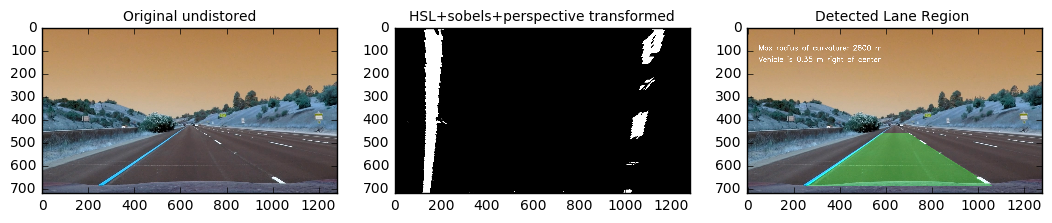

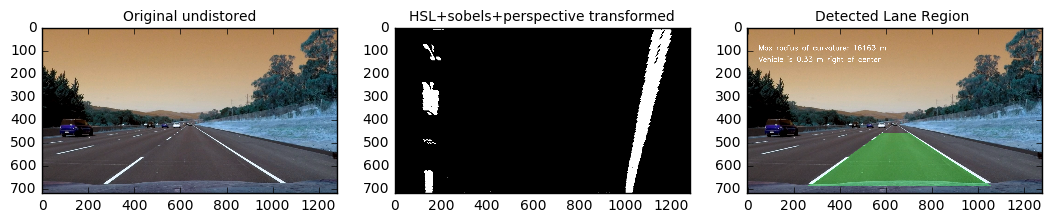

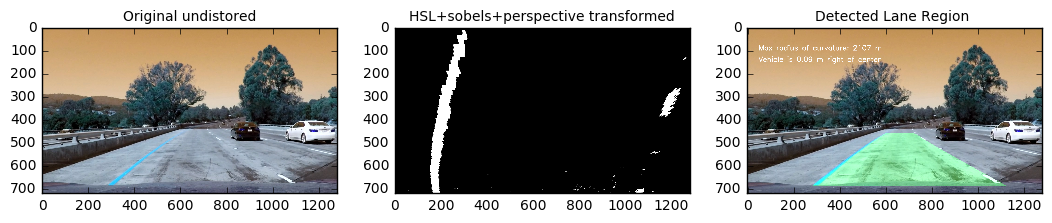

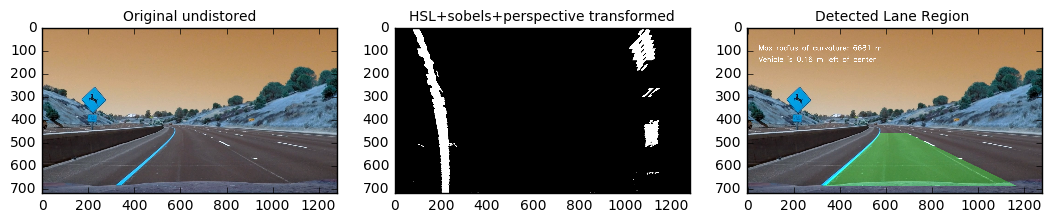

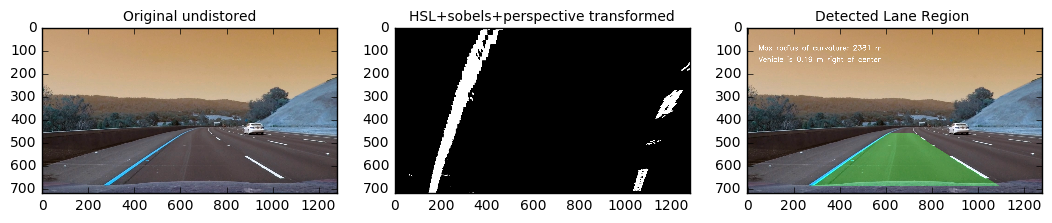

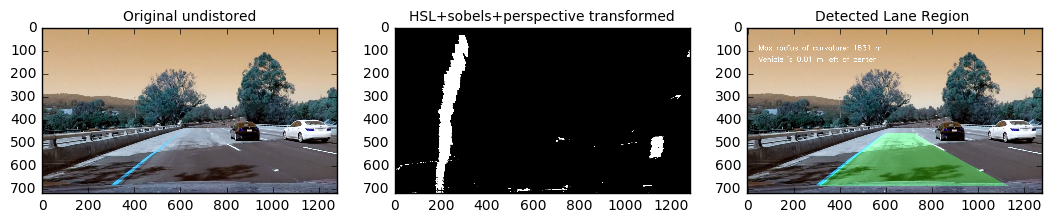

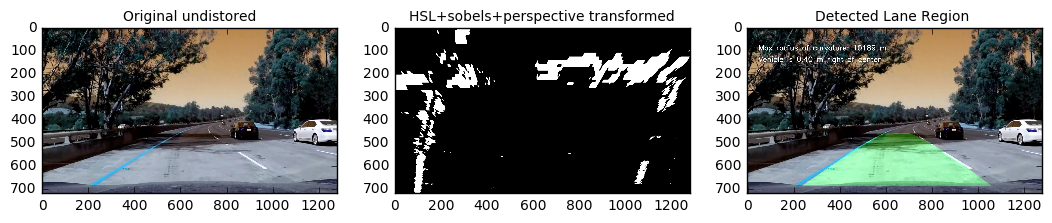

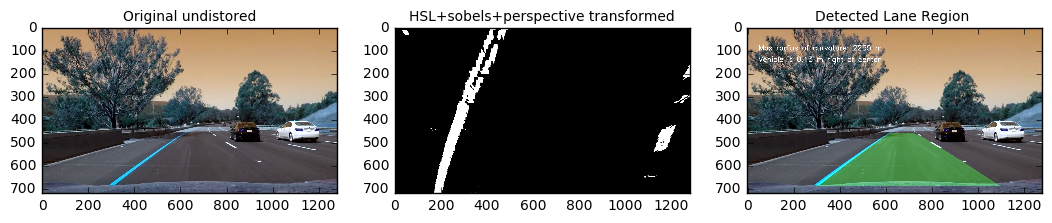

In [18]:
test_images_path = "./test_images/*.jpg"
%matplotlib inline

images_path = glob.glob(test_images_path)

for idx, fname in enumerate(images_path):
    img = cv2.imread(fname)
    
    undst_img_test, HLS_sbl_pt_img, result = final_pipeline(img,objpoints, imgpoints)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,5))
    
    f.tight_layout()

    ax1.imshow(undst_img_test,cmap="jet")
    
    ax1.set_title("Original undistored", fontsize=10)
    
    ax2.imshow(HLS_sbl_pt_img,cmap="gray")
    
    ax2.set_title("HSL+sobels+perspective transformed", fontsize=10)
    
    ax3.imshow(result,cmap="jet")
    
    ax3.set_title("Detected Lane Region ", fontsize=10)

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    

### tesing the pipeline in video

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
white_output = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [23:23<00:01,  1.20s/it]    | 1/1261 [00:01<21:43,  1.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 21min 19s, sys: 1min 40s, total: 22min 59s
Wall time: 23min 25s


### conclusion 

The final output of the video is output.mp4 

As we can see in the video, the main pipeline is capable of detecting the drawing the region of interest within the lanes most of the time. However, when there are some very significant change in color within the region(i.e: shawdow, etc) the region might not been hightlighted properly. 